In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [2]:
# To look at the signals with.
class Scope():
    def __init__(self, rate):
        self.ts = 1 / rate

    def __call__(self, samps, samps2=None):
        fig, ax = plt.subplots()
        ax.grid(True)
        xs = np.arange(len(samps)) * self.ts
        if samps2 is not None:
            ax.plot(xs, samps, xs, samps2)
        else:
             ax.plot(xs, samps)

In [3]:
# Signal generator.
class Sinusoid():
    def __init__(self, rate, freq, amplitude=1.0, phase=0):
        self.rate = rate
        self.ts = 1 / rate
        self.A = amplitude
        self.w = 2 * np.pi * freq
        self.ph = phase
        self.n = 0

    def feed(self):
        r = self.A * np.sin(self.w * self.n * self.ts + self.ph)
        self.n += 1
        return r

    def __call__(self, samps):
        return np.array([self.feed() for i in range(samps)])

In [4]:
def dc(volts, samps):
    return np.ones(shape=samps) * volts

In [5]:
class RC_filter():
    def __init__(self, sample_freq, RC):
        self.k = 1.0 / (RC * sample_freq)
        self.y = 0

    def feed(self, samp):
        self.y += self.k * (samp - self.y)
        return self.y

    def __call__(self, samps):
        return np.array([self.feed(s) for s in samps])

In [6]:
class QuadratureMixer():
    def __init__(self, tune, RC, oversamp=100):
        self.rate = oversamp * tune
        self.tune = tune
        self.oversamp = oversamp
        self.scope = Scope(self.rate)
        self.filt_I = RC_filter(self.rate, RC)
        self.filt_Q = RC_filter(self.rate, RC)

    def sample_rate(self):
        return self.rate
    
    def freq(self):
        return self.tune

    def cycle(self, sgen):
        qtr = self.oversamp // 4
        filt_I = self.filt_I
        filt_Q = self.filt_Q
        
        I1 = filt_I(sgen(qtr))
        Q1 = dc(volts=filt_Q.y, samps=qtr)
 
        I2 = dc(volts=filt_I.y, samps=qtr)
        Q2 = filt_Q(sgen(qtr))

        I3 = filt_I(-sgen(qtr))
        Q3 = dc(volts=filt_Q.y, samps=qtr)
 
        I4 = dc(volts=filt_I.y, samps=qtr)
        Q4 = filt_Q(-sgen(qtr))

        I = np.concatenate([I1, I2, I3, I4])
        Q = np.concatenate([Q1, Q2, Q3, Q4])
 
        return I,Q

    def __call__(self, sgen, cycles):
        cycles = int(cycles)
        vv = np.array([self.cycle(sgen) for i in range(cycles)])
        I = np.concatenate(vv[:, 0])
        Q = np.concatenate(vv[:, 1])

        return I,Q

In [7]:
# Convenient units.
MHz = 1e6; kHz = 1e3; Hz=1
uF = 1e-6; nF = 1e-9; pF = 1e-12
usec = 1e-6; msec = 1e-3; sec = 1
ohms = 1

In [9]:
EnsembleRX = partial(QuadratureMixer, RC = 26.5*ohms * 0.047*uF)
rx = EnsembleRX(7.0*MHz)

rate = rx.sample_rate()
sgen = Sinusoid(rate, freq=7*MHz + 1*kHz, phase=2*np.pi/8)
sgen2 = Sinusoid(rate, freq=21*MHz + 1*kHz, phase=2*np.pi/8)


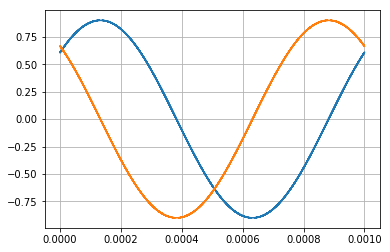

In [12]:
I,Q = rx(Sinusoid(rate, freq=7*MHz + 1*kHz), cycles=rx.freq()*1*msec)
rx.scope(I, Q)

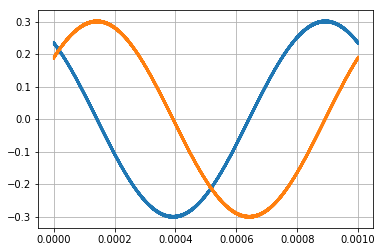

In [15]:
I,Q = rx(Sinusoid(rate, freq=3*7*MHz + 1*kHz), cycles=rx.freq()*1*msec)
rx.scope(I, Q)

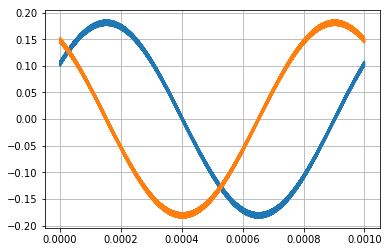

In [17]:
I,Q = rx(Sinusoid(rate, freq=5*7*MHz + 1*kHz), cycles=rx.freq()*1*msec)
rx.scope(I, Q)

Notes:
- Here is the [schematic](softrock-bw.pdf).
- For the I component to be truly in phase the received signal needs to be phase delayed by 45 degrees, as done in the signal generator.  This is okay, because there is nothing magic about the phase of the local oscillator--it just starts whenever you turn it on.
- You can see that with this 45-degree phase delay, the I half of the detector is centered on the two peaks, and the Q side of the detector is centered on the two zeros.
- The sound card sees many copies of these single-cycle waveforms during its audio sample.  The average that it sees is indicated in one of the plots.
- The small amount of ripple you see at the detector output passes through the op amp gain stage before being passed on to the sound card, and so the bandwidth there would likely attenuate the ripple some.
-  The amount of ripple is really determined by the source impedance and the sampling capacitor, which is really just a filter capacitor.  You can make it larger and get less ripple, but then you'd increase the time to achieve steady state.  I believe that time is on the order of several time constants for the filter.  With the parts shown, the time constant is about 12.5 microseconds.
- I think this also sets the bandwidth that you have available for sampling with the sound card.  If you have a fancy high-bandwidth sound card these component values might be limiting, but I need to work through that to be sure.  It seems that the bandwidth here might be around 30 kHz on each channel.